KMO Test Score: 0.895

KMO (Kaiser-Meyer-Olkin) Test assesses the suitability of data for factor analysis. 

Bartlett’s Test p-value: 0.833


/tmp/ipykernel_8340/2369382829.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  questions_data.fillna(questions_data.mean(), inplace=True)


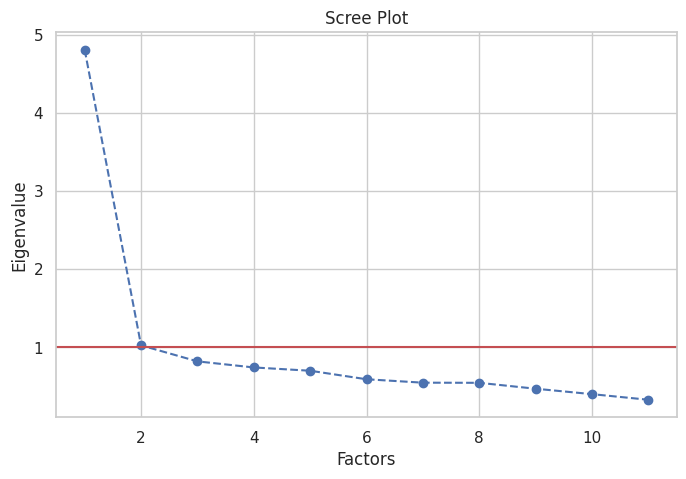

Optimal number of factors: 2


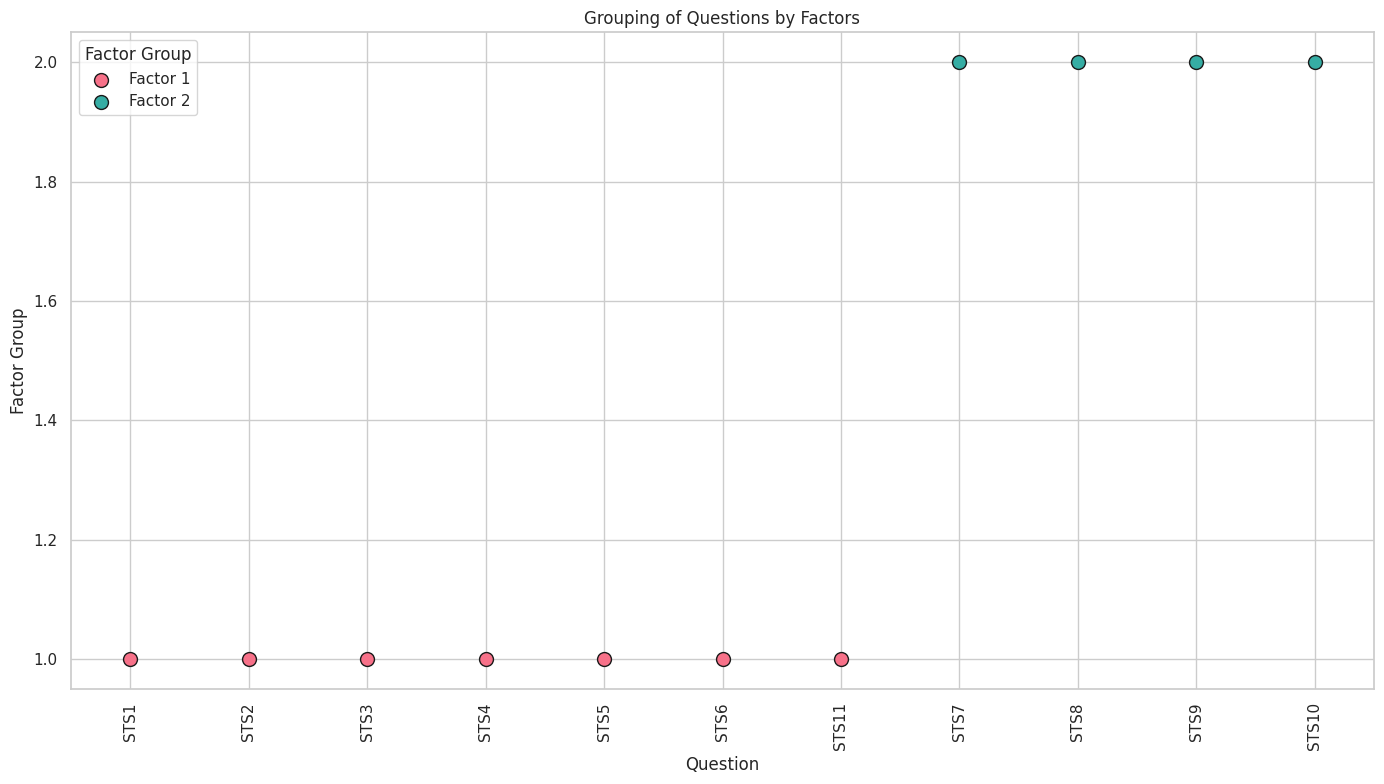

Grouped Questions by Factor:
   Question  Factor Group
0      STS1             1
1      STS2             1
2      STS3             1
3      STS4             1
4      STS5             1
5      STS6             1
6     STS11             1
7      STS7             2
8      STS8             2
9      STS9             2
10    STS10             2
Mean Distances Between Groups:
          1         2
1  0.000000  0.492217
2  0.492217  0.000000
Mean distance within group 1: 0.2295
Mean distance within group 2: 0.2873


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_kmo
from scipy.stats import bartlett

# Load the data from CSV
file_name = 'data.csv'
data = pd.read_csv(file_name)

# Clean column names and select only the question columns
data.columns = data.columns.str.strip().str.upper()
questions_columns = [col for col in data.columns if col.startswith(('K', 'VE', 'ST', 'E', 'A'))]
questions_data = data[questions_columns]

# Handle missing values by filling with column means
questions_data.fillna(questions_data.mean(), inplace=True)

# Standardize the data
scaler = StandardScaler()
questions_data_scaled = scaler.fit_transform(questions_data)

# Regularization for factor analysis
def regularize(data):
    epsilon = 1e-8
    return data + epsilon

questions_data_scaled_reg = regularize(questions_data_scaled)

# Perform KMO and Bartlett’s Test
try:
    kmo_all, kmo_model = calculate_kmo(questions_data_scaled_reg)
    print(f"KMO Test Score: {kmo_model:.3f}")
    print("\nKMO (Kaiser-Meyer-Olkin) Test assesses the suitability of data for factor analysis. \n")
except Exception as e:
    print(f"Error in KMO calculation: {e}")

try:
    chi_square_value, p_value = bartlett(*[questions_data[col] for col in questions_columns])
    print(f"Bartlett’s Test p-value: {p_value:.3f}")
except Exception as e:
    print(f"Error in Bartlett’s Test calculation: {e}")

# Perform Factor Analysis
fa = FactorAnalyzer(rotation=None)
fa.fit(questions_data_scaled_reg)

# Get eigenvalues to determine the optimal number of factors
eigenvalues, _ = fa.get_eigenvalues()

# Plot a Scree Plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.axhline(y=1, color='r', linestyle='-')
plt.show()

# Determine the number of factors with eigenvalue > 1
optimal_factors = sum(eigenvalues > 1)
print(f'Optimal number of factors: {optimal_factors}')

# Perform Factor Analysis with the optimal number of factors
fa_optimal = FactorAnalyzer(n_factors=optimal_factors, rotation='promax')
fa_optimal.fit(questions_data_scaled_reg)

# Get Factor Loadings
factor_loadings = pd.DataFrame(fa_optimal.loadings_, index=questions_columns)

# Save factor loadings to CSV
factor_loadings.to_csv('factor_loadings.csv')

# Assign sequential group numbers
factor_loadings_df = factor_loadings.copy()
factor_loadings_df['Group'] = np.argmax(fa_optimal.loadings_, axis=1) + 1

# Ensure no missing factor numbers
unique_factors = np.unique(factor_loadings_df['Group'])
factor_mapping = {old_group: new_group for new_group, old_group in enumerate(sorted(unique_factors), start=1)}
factor_loadings_df['Group'] = factor_loadings_df['Group'].map(factor_mapping)

# Create a DataFrame for grouped questions
grouped_questions_df = factor_loadings_df.reset_index()
grouped_questions_df.columns = ['Question'] + [f'Factor_{i + 1}' for i in range(optimal_factors)] + ['Group']
grouped_questions_df = grouped_questions_df[['Question', 'Group']]

# Sort the DataFrame by 'Group' column
grouped_questions_df.sort_values(by='Group', inplace=True)

# Reset index after sorting
grouped_questions_df.reset_index(drop=True, inplace=True)

# Rename the Group column for clarity
grouped_questions_df.rename(columns={'Group': 'Factor Group'}, inplace=True)

# Plot the factor loadings
plt.figure(figsize=(14, 8))
sns.set(style="whitegrid")

# Create a color palette for the factors
palette = sns.color_palette("husl", len(grouped_questions_df['Factor Group'].unique()))

# Plot each factor with a different color
for factor, color in zip(grouped_questions_df['Factor Group'].unique(), palette):
    subset = grouped_questions_df[grouped_questions_df['Factor Group'] == factor]
    plt.scatter(subset['Question'], [factor] * len(subset), label=f'Factor {factor}', s=100, edgecolor='k', color=color)

plt.xticks(rotation=90)
plt.xlabel('Question')
plt.ylabel('Factor Group')
plt.title('Grouping of Questions by Factors')
plt.legend(title='Factor Group')
plt.tight_layout()

# Save the plot
plt.savefig('grouped_questions_plot.png')
plt.show()

# Save the grouped questions to CSV
grouped_questions_df.to_csv('grouped_questions.csv', index=False)

# Display the grouped questions
print("Grouped Questions by Factor:")
print(grouped_questions_df)

# Load factor loadings data from CSV
factor_loadings_df = pd.read_csv('factor_loadings.csv', index_col=0)

# Create a DataFrame for mapping groups
group_mapping = dict(zip(grouped_questions_df['Question'], grouped_questions_df['Factor Group']))

# Convert factor loadings to a NumPy array for faster calculations
factor_loadings_array = factor_loadings_df.iloc[:, :-1].values

# Calculate mean distances between each pair of groups
unique_groups = grouped_questions_df['Factor Group'].unique()

distance_matrix = pd.DataFrame(np.zeros((len(unique_groups), len(unique_groups))), 
                               index=unique_groups, columns=unique_groups)

group_ids = [group_mapping[q] for q in factor_loadings_df.index]

for group_i in unique_groups:
    for group_j in unique_groups:
        if group_i != group_j:
            indices_i = [idx for idx, group in enumerate(group_ids) if group == group_i]
            indices_j = [idx for idx, group in enumerate(group_ids) if group == group_j]

            distances = []
            
            for idx_i in indices_i:
                for idx_j in indices_j:
                    dist = np.abs(factor_loadings_array[idx_i] - factor_loadings_array[idx_j])
                    distances.extend(dist)
            
            mean_distance = np.mean(distances)
            distance_matrix.loc[group_i, group_j] = mean_distance

# Display the matrix showing the mean distances between each pair of groups
print("Mean Distances Between Groups:")
print(distance_matrix)

# Save the distance matrix to CSV
distance_matrix.to_csv('mean_distances_between_groups.csv')

# Calculate mean distances within each group
group_mean_distances = {}

for group in unique_groups:
    group_questions = [q for q in factor_loadings_df.index if group_mapping.get(q) == group]

    if len(group_questions) < 2:
        group_mean_distances[group] = 0
        continue

    group_data = factor_loadings_df.loc[group_questions].iloc[:, :-1]

    pairwise_diffs = []
    for i in range(len(group_questions)):
        for j in range(i + 1, len(group_questions)):
            dist = np.abs(group_data.iloc[i] - group_data.iloc[j])
            pairwise_diffs.extend(dist)

    group_mean_distance = np.mean(pairwise_diffs)
    group_mean_distances[group] = group_mean_distance

# Display mean distances within each group
for group, mean_distance in group_mean_distances.items():
    print(f"Mean distance within group {group}: {mean_distance:.4f}")

# Save the mean distances to a CSV file
mean_distances_df = pd.DataFrame.from_dict(group_mean_distances, orient='index', columns=['Mean Distance'])
mean_distances_df.to_csv('mean_distances_within_groups.csv')
